# Evolutionary Hill Climbing (EHC) algorithm (3-bit parity Dataset)

Next we will train a neural network model on a more complex dataset: the 3 bit parity dataset.

3 bit parity dataset:

| A | B | C | Output |
|---|---|---|--------|
| 0 | 0 | 0 | 0      |
| 0 | 0 | 1 | 1      |
| 0 | 1 | 0 | 1      |
| 0 | 1 | 1 | 0      |
| 1 | 0 | 0 | 1      |
| 1 | 0 | 1 | 0      |
| 1 | 1 | 0 | 0      |
| 1 | 1 | 1 | 1      |

Firstly we will create our input (x) dataset using Numpy arrays. Next we will append a 1 to the front of each input (x) sample, representing our bias input. Finally we will create our output (y) dataset.

In [10]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# define input data
x = np.array([
    [0, 0, 0],
    [0, 0, 1],
    [0, 1, 0],
    [0, 1, 1],
    [1, 0, 0],
    [1, 0, 1],
    [1, 1, 0],
    [1, 1, 1],
])

# append bias
x = [np.append(1, x) for x in x]  

# define target data
y = np.array([[0, 1, 1, 0, 1, 0, 0, 1]]).T

Now we will define our network's structure using a *connectivity matrix*. It is easiest to read this matrix column-by-column, where each 1 in a column represents a node that the current node maps to.

The following matrix represents the network we are implementing in this example.

|                | bias | input_0 | input_1 | input_2 | hidden_layer_1 | hidden_layer_2 | output |
|----------------|------|---------|---------|---------|----------------|----------------|--------|
| bias           | 0    | 0       | 0       | 0       | 0              | 0              | 0      |
| input_0        | 0    | 0       | 0       | 0       | 0              | 0              | 0      |
| input_1        | 0    | 0       | 0       | 0       | 0              | 0              | 0      |
| input_2        | 0    | 0       | 0       | 0       | 0              | 0              | 0      |
| hidden_layer_1 | 1    | 1       | 1       | 1       | 0              | 0              | 0      |
| hidden_layer_2 | 1    | 1       | 1       | 1       | 0              | 0              | 0      |
| output         | 1    | 0       | 0       | 0       | 1              | 1              | 0      |

Represented visually:

![alt text](nn_3bit.png "Neural Network Model")

In [11]:
node_labels = ['bias', 'input_0', 'input_1', 'input_2', 'hidden_layer_1', 'hidden_layer_2', 'output']

# connectivity matrix of network
network_matrix = np.array([
    [0, 0, 0, 0, 0, 0, 0], #bias
    [0, 0, 0, 0, 0, 0, 0], #input_0
    [0, 0, 0, 0, 0, 0, 0], #input_1
    [0, 0, 0, 0, 0, 0, 0], #input_2
    [1, 1, 1, 1, 0, 0, 0], #hidden_layer_1
    [1, 1, 1, 1, 0, 0, 0], #hidden_layer_2
    [1, 0, 0, 0, 1, 1, 0], #output
])

Next we will transform this matrix into an adjacency list, which will make our calculations easier to perform (we are not concerned with zeros in the above matrix). 

In [12]:
def generate_adjacency_list():
    rows, cols = np.nonzero(network_matrix) # get locations of non-zero elements of network matrix (ie connections)
    d = defaultdict(list)
    [d[row].append(col) for row, col in zip(rows, cols)] # build dictionary mapping a node to all incoming connections

    return d

network_list = generate_adjacency_list()

# print adjacency list
for node, incoming_nodes in network_list.items():
    print("Node:",node_labels[node],"Incoming nodes:",[node_labels[k] for k in incoming_nodes])

Node: hidden_layer_1 Incoming nodes: ['bias', 'input_0', 'input_1', 'input_2']
Node: hidden_layer_2 Incoming nodes: ['bias', 'input_0', 'input_1', 'input_2']
Node: output Incoming nodes: ['bias', 'hidden_layer_1', 'hidden_layer_2']


The next step is to generate random weights for each connection in the matrix. To do this, we will create a new matrix of the same size as the connectivity matrix and replace any connections with random numbers.

In [13]:
def generate_random_weights():
    weights = np.zeros(network_matrix.shape)
    for row, columns in network_list.items(): 
        for column in columns: # for all edges in network
            weights[row][column] = np.random.normal() # set weight of edge to random value

    return weights

weights = generate_random_weights()

# print weights matrix
print(np.round(weights,3))

[[ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.258 -0.311  1.015  1.357  0.     0.     0.   ]
 [ 0.722 -0.439 -1.284 -0.15   0.     0.     0.   ]
 [-0.458  0.     0.     0.    -0.829 -0.703  0.   ]]


Now we want to *evaluate* the network with the current random weights. Will will use root-mean-squared-error as our error function and sigmoid as our activation function.

In [14]:
def activate(x, a=1, b=0):
    return 1 / (1 + np.exp(-a * x - b))  # sigmoid function

def predict(x, weights):
    node_values = x # current node values (as we are evaluating nodes in order)
    for row, columns in network_list.items(): # for all nodes in network
        node_value = 0
        for column in columns: # for all edges in network
            node_value += weights[row][column] * node_values[column] # sum the product of the incoming connections with the from node's value
        node_values = np.append(node_values, activate(node_value))

    return node_values[-1]

def evaluate(x, y, weights):
    sum_squared_error = 0
    for x_sample, y_sample in zip(x, y): # for each sample in dataset
        prediction = predict(x_sample, weights) # get prediction
        error = y_sample - prediction # calculate error margin (difference between expected and predicted values)
        sum_squared_error += np.power(error, 2) # square error
    return np.sqrt(sum_squared_error) # return root mean squared error

error = evaluate(x, y, weights)

Before we begin training our network, we need to determine how we will mutate the weights in the network. Given a step amount, the following function will add 

$step\_amount * random\_number $

to each weight.

In [16]:
def mutate(weights, step_amount):
    weights_mutated = weights.copy()
    for row, columns in network_list.items(): # for all nodes in network
        for column in columns: # for all edges in network
            weights_mutated[row][column] += step_amount * np.random.normal() # add step amount * random value

    return weights_mutated

Now we are ready to train! We will train until either we reach a set number of iterations or our error is less than a set error goal.

In [17]:
STEP_SIZE = 0.02
NUM_ITERATIONS = 50000
ERROR_GOAL = 0.1

counter = 0
errors = []

while ERROR_GOAL < error and NUM_ITERATIONS > counter:
    step_amount = STEP_SIZE * np.random.normal() # calculate step amount for this iteration

    weights_mutated = mutate(weights, step_amount) # mutate weights

    error_weights_mutated = evaluate(x, y, weights_mutated) # calculate error of network with mutated weights

    # print error every 1000 iterations
    if counter % 1000 == 0:
        print("Error at iteration",counter,":\t",error_weights_mutated)
        
    # store current error in list for plotting
    errors.append(error_weights_mutated)

    # if mutated weights are better than the current weights, update
    if error_weights_mutated < error:
        weights = weights_mutated
        error = error_weights_mutated

    counter += 1

Error at iteration 0 :	 [1.64584729]
Error at iteration 1000 :	 [1.39046446]
Error at iteration 2000 :	 [1.25527975]
Error at iteration 3000 :	 [1.00204503]
Error at iteration 4000 :	 [0.79017184]
Error at iteration 5000 :	 [0.63765565]
Error at iteration 6000 :	 [0.54395833]
Error at iteration 7000 :	 [0.46387312]
Error at iteration 8000 :	 [0.40224157]
Error at iteration 9000 :	 [0.34735964]
Error at iteration 10000 :	 [0.31208263]
Error at iteration 11000 :	 [0.27779369]
Error at iteration 12000 :	 [0.24842667]
Error at iteration 13000 :	 [0.22451784]
Error at iteration 14000 :	 [0.20439285]
Error at iteration 15000 :	 [0.18350287]
Error at iteration 16000 :	 [0.17509325]
Error at iteration 17000 :	 [0.16163544]
Error at iteration 18000 :	 [0.1511666]
Error at iteration 19000 :	 [0.14685501]
Error at iteration 20000 :	 [0.13627142]
Error at iteration 21000 :	 [0.13936109]
Error at iteration 22000 :	 [0.1249897]
Error at iteration 23000 :	 [0.11389141]
Error at iteration 24000 :	 [0.

To test the network, we will generate predictions for all training samples (x) and compare these with the expected values (y).

In [18]:
correct_predictions = 0

for x_i, y_i in zip(x, y): # for each sample in dataset
    prediction = np.round(predict(x_i, weights)) # get prediction
    if prediction == y_i: # if prediction is correct, add 1 to correct_predictions
        correct_predictions += 1
    print("Input:", x_i, "Target:", y_i, "Prediction:", [int(prediction)])

print("Accuracy:",correct_predictions/len(x) * 100,"%") # display accuracy

Input: [1 0 0 0] Target: [0] Prediction: [0]
Input: [1 0 0 1] Target: [1] Prediction: [1]
Input: [1 0 1 0] Target: [1] Prediction: [1]
Input: [1 0 1 1] Target: [0] Prediction: [0]
Input: [1 1 0 0] Target: [1] Prediction: [1]
Input: [1 1 0 1] Target: [0] Prediction: [0]
Input: [1 1 1 0] Target: [0] Prediction: [0]
Input: [1 1 1 1] Target: [1] Prediction: [1]
Accuracy: 100.0 %


Finally we can plot the error curve to visualise how the network improved over the course of training.

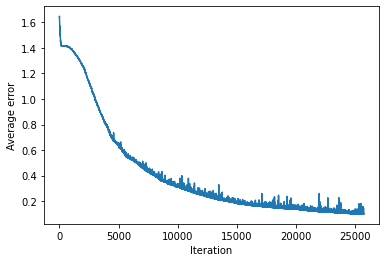

In [19]:
# plot error curve

plt.plot(range(counter), errors)
plt.xlabel("Iteration")
plt.ylabel("Average error")
plt.show()